In [1]:
import sys
!{sys.executable} -m pip install opencv-python

In [19]:
import cv2
import numpy as np
import math 

# Create the haar cascade
faceCascade = cv2.CascadeClassifier("./data/haarcascade_frontalface_default.xml")

# Read the image
image = cv2.imread("./data/side.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
lab = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Detect faces in the image
faces = faceCascade.detectMultiScale(
    gray,
    scaleFactor=1.1,
    minNeighbors=5,
    minSize=(30, 30)
)


In [20]:
# Draw a rectangle around the face and get the corresponding area
for (x, y, w, h) in faces:
    face = image[y:y+h,x:x+w]
    face_gray= gray[y:y+h,x:x+w]
    face_rect_lab = lab[y:y+h,x:x+w]
    face_rect_hsv = hsv[y:y+h,x:x+w]

cv2.imshow("Face Found",image)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.imshow("Face Mask LAB",face_rect_lab)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.imshow("Face Mask HSV",face_rect_hsv)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [21]:
from scipy.signal import convolve2d

# Get skin mask
def elipse_mask(a,b):
    return ((a-143.0)/6.5)**2 + ((b-148.0)/12)**2

def elipse_mask_imp(a,b):
    return math.sqrt((a-143)**2+(b-148)**2)-90

def hsv_mask(h,s):
    return (s>=0.25 and s<=0.75) and h<=0.095


def skin_detection():
    skin_mask = np.zeros((face.shape[0],face.shape[1]))
    avg_mask = np.ones((5,5))/25
    a_mean = convolve2d(face_rect_lab[:,:,1],avg_mask,mode='same',boundary='symm')
    b_mean = convolve2d(face_rect_lab[:,:,2],avg_mask,mode='same',boundary='symm')
    ellipse_test = np.vectorize(lambda a,b: 1 if elipse_mask(a,b) < 1 else (math.sqrt((a-143)**2+(b-148)**2)-90)/-78 if elipse_mask_imp(a,b) < 0 else 0)
    skin_mask = ellipse_test(a_mean,b_mean)
    hsv_test = np.vectorize(lambda h,s,m: 1 if m > 0.95 and hsv_mask(h,s) else 0)
    skin_mask = hsv_test(face_rect_hsv[:,:,0]/179.0,face_rect_hsv[:,:,1]/255.0,skin_mask)
    large_ellipse_test = np.vectorize(lambda m,a,b: 1 if elipse_mask(a,b) < 1.25 and m == 1 else 0)
    skin_mask = large_ellipse_test(skin_mask,a_mean,b_mean)

    return skin_mask.astype(np.uint8)
    
skin_mask = skin_detection()

skin = cv2.bitwise_and(face, face, mask = skin_mask)
cv2.imshow("Skin Found",np.hstack([face,skin]))
cv2.waitKey(0)
cv2.destroyAllWindows()

In [22]:
# Adapted from https://github.com/drakeguan/cp11fall_project1/blob/master/wlsFilter/wlsFilter.m
from scipy.sparse import spdiags
from scipy.sparse.linalg import spsolve
def wls_filter(img_l,alpha=1.2,l=0.5, eps=sys.float_info.epsilon):
    
    img_l = img_l.astype(float)/255.0
    r,c = img_l.shape
    k = r*c;

    # Compute affinities between adjacent pixels based on gradients of L
    dy = np.diff(img_l, 1, 0);
    dy = -l / (np.absolute(dy)**alpha + eps)
    dy = (np.vstack((dy, np.zeros(c, )))).flatten('F')

    dx = np.diff(img_l, 1, 1); 
    dx = -l / (np.absolute(dx)**alpha + eps)
    dx = (np.hstack((dx, np.zeros(r, )[:, np.newaxis]))).flatten('F')


    # Construct a five-point spatially inhomogeneous Laplacian matrix
    B = np.vstack((dx,dy))
    d = [-r,-1]
    A = spdiags(B,d,k,k)

    e = dx
    w = np.roll(dx,r)
    s = dy
    n = np.roll(dy,1)

    D = 1 - (e+w+s+n);
    A = A + A.T + spdiags(D, 0, k, k);

    #Solve
    OUT = spsolve(A, img_l.flatten('F')).reshape(img_l.shape[::-1])
    
    base = np.rollaxis(OUT,1)
    detail = img_l - base
    return (base,detail)




In [23]:
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

def hist_smoothing(skin,ksize=30,sigma=10):
    intensity = (skin*255).clip(0,255).astype(np.uint8)
    hist = cv2.calcHist([intensity],[0],None,[255],[1,256]).T.ravel()
    plt.plot(hist)
    plt.show()
    hist = np.correlate(hist,cv2.getGaussianKernel(ksize,sigma).ravel(),'same')
    plt.plot(hist)
    plt.show()
    return hist

def bimodal_check(hist):
    peaks = argrelextrema(hist,np.greater,order=5)[0]
    if len(peaks) < 2:
        return False, -1, -1, -1
    max_peak = np.argmax(hist[peaks])
    left = peaks[:max_peak]
    right = peaks[max_peak+1:]
    refined_peaks_left = argrelextrema(hist[left],np.greater_equal,order=1,mode='clip')[0]
    refined_peaks_right = argrelextrema(hist[right],np.greater_equal,order=1,mode='clip')[0]
    other_peak = -1
    if len(refined_peaks_left) > 0 and len(refined_peaks_right) > 0:
        other_peak = left[refined_peaks_left[0]] if refined_peaks_left[0] < refined_peaks_right[-1] else right[refined_peaks_right[-1]]
    elif len(refined_peaks_left) > 0:
        other_peak = left[refined_peaks_left[0]]
    else:
        other_peak = right[refined_peaks_right[-1]]      
    if other_peak == -1:
        dist_from_max = np.absolute(peaks-peaks[max_peak])
        max_distant_peak = np.argmax(dist_from_max)
        other_peak = peaks[max_distant_peak]       
    d = peaks[max_peak] if peaks[max_peak] < other_peak else other_peak
    b = peaks[max_peak] if peaks[max_peak] > other_peak else other_peak
    m = np.argmin(hist[d:b])+d

    return True, d, m, b

In [26]:
"""
Algorithm 1. CorrectFace(I,F,Mskin)
Require: I – input image (luminance channel).
Require: F – detected face rectangle.
Require: Mskin – skin mask.
Ensure: Iout – adjusted image (luminance channel).
1: // Perform edge-preserving base/detail decomposition
2: (Base,Detail) = W LSFilter(I)
3: Iout = Base
4: // Sidelight correction
5: S = F Mskin // skin pixels inside F
6: H = Smoothed histogram of intensities in Iout[S]
7: if H is bimodal (sidelit face) then
8: d = intensity of dark mode in H
9: b = intensity of bright mode in H
10: m = intensity at local minimum between d and b
11: f = b−d m−d
12: A = adjustment map scaling by f every pixel ∈ S
with intensity ≤ m
13: Apply edge-aware constraint propagation to A
14: Iout = Iout ·A // pixelwise multiplication
15: end if
16: // Exposure Correction
17: p = 75th percentile of face skin pixels S
18: if p < 120 (underexposed face) then
19: f = 120+p
2p ; ensure 1 ≤ f ≤ 2
20: A = adjustment map scaling by f every pixel ∈ S
21: Apply edge-aware constraint propagation to A
22: Iout = Iout ·A // pixelwise multiplication
23: end if
24: Iout+ = Detail
"""

def side_adjustment_map(skin, m, f, A):
    if ((skin > 0) & (skin<=m)).all():
        A[skin] = f
    else:
        A[skin] = 1

    return A

def exposed_adjustment_map(skin, f, A):
    if skin.all()>0:
        A[skin] = f
    else:
        A[skin] = 1
    return A

def correct_face(img, face, skin_mask):
    # Perform edge-preserving base/detail decomposition
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    (base, detail) = wls_filter(lab[:,:,0])
    
    cv2.imshow("Base",base)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    img_out = base
    
    skin = cv2.bitwise_and(face, face, mask = skin_mask)

    hist = hist_smoothing((skin*255).clip(0,255).astype(np.uint8))
    
    bimodal, d, b, m = bimodal_check(hist)
    
    # Sidelight correction
    if bimodal:
        print("Is bimodal")
        i_side = (img_out*255).clip(0,255).astype(np.uint8)
        f = (b-d)/(m-d)
        s = skin*255
        A = np.ones(i_side.shape)
        print(A[y:y+h,x:x+w].shape)
        A = side_adjustment_map(s, m, f, A)
        # Apply edge-aware constraint propagation to A
        img_out = i_side * A  # pixelwise multiplication
        cv2.imshow("Side ",img_out)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    
    # Exposure Correction
    cum_sum = cv2.calcHist([(skin).astype('uint8')],[0],None,[255],[1,256]).T.ravel().cumsum()
    plt.plot(cum_sum)
    plt.show()
    p = np.searchsorted(cum_sum, cum_sum[-1] * 0.75)
    A = np.ones(img_out.shape)
    if p < 120:
        print("Is underexposed")
        i_exp = (img_out*255).clip(0,255).astype(np.uint8)
        f = (120+p)/(2*p)
        if f <= 2 and f >= 1:
            A = np.ones(i_exp.shape)
            A = exposed_adjustment_map(skin, f, A)
            #Apply edge-aware constraint propagation to A
            img_out = i_exp * A #pixelwise multiplication
            cv2.imshow("Exp ",img_out)
            cv2.waitKey(0)
            cv2.destroyAllWindows()
    
    img_out+= detail
    
    return img_out

C:\Users\gbata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:168: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


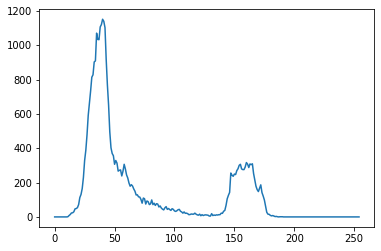

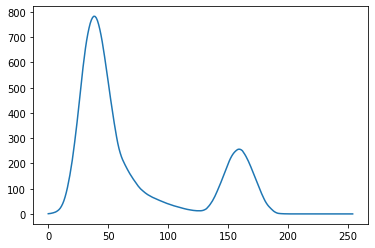

Is bimodal
(335, 335)


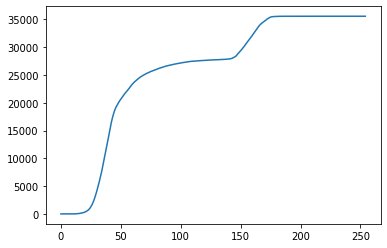

Is underexposed


In [27]:
img_out = correct_face(image,face,skin_mask)

In [93]:
cv2.imshow("Original",gray)
cv2.imshow("Final Result",img_out)
cv2.waitKey(0)
cv2.destroyAllWindows()